In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import pandas as pd

In [5]:
# Ссылка на скачивание данных в формате CSV
csv_data_url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vT3Wns_gLiMDfacVgF-x4suNvnAFmgibVkrsizkKqwcVFGSYAVOVnJsoV7gm3jguw/pub?gid=681978523&single=true&output=csv"

# Загрузка данных в DataFrame
data = pd.read_csv(csv_data_url)

# Просмотр первых нескольких строк данных
print(data.head())

   Unnamed: 0                                       problem_text  \
0           0  To prove that the sum of the numbers of the ex...   
1           1  ( b) Will the statement of the previous challe...   
2           2  The quadratic three-member graph with the coef...   
3           3  Can you draw on the surface of Rubik's cube a ...   
4           4  Dima, who came from Vrunlandia, said that ther...   

           topic  
0  number_theory  
1  number_theory  
2       polynoms  
3  combinatorics  
4         graphs  


Пойдем решать задачу по плану

# Подготовка данных:

# Анализ и балансировка классов:
# 

Посмотрим, сколько примеров есть в каждом классе (теме).   
Если некоторые классы недопредставлены, может потребоваться выполнить **дополнительные шаги**, 
такие как аугментация данных для меньших классов или использование взвешивания классов при обучении модели.

# Шаг 1: Сбор данных
Проверим сбалансированность классов. Ты можешь использовать следующий код для отображения количества примеров для каждого класса:

In [6]:
print(data.columns)

Index(['Unnamed: 0', 'problem_text', 'topic'], dtype='object')


topic
number_theory    2396
combinatorics    1020
dirichlet         441
polynoms          426
graphs            384
geometry          371
invariant         235
Name: count, dtype: int64


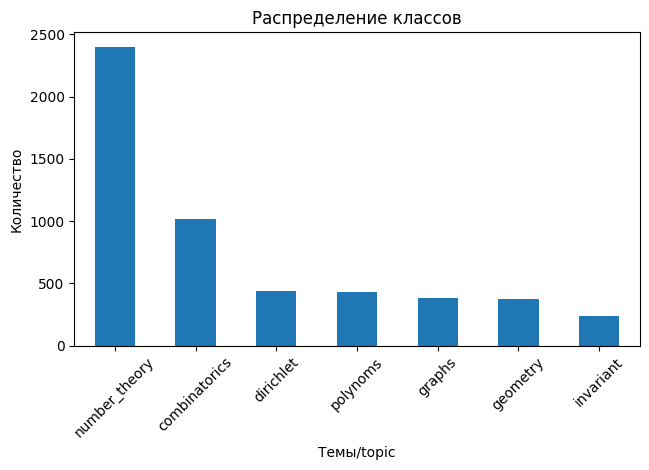

In [7]:
import matplotlib.pyplot as plt

# Предполагая, что у тебя есть колонка 'theme' для тем в твоем DataFrame 'data'
class_counts = data['topic'].value_counts()

# Выведем количество данных по каждой теме
print(class_counts)

# Построим график распределения классов
class_counts.plot(kind='bar')
plt.title('Распределение классов')
plt.xlabel('Темы/topic')
plt.xticks(rotation=45)
plt.tight_layout()
plt.ylabel('Количество')
plt.show()


Если распределение классов сильно несбалансировано, рассмотри возможность использования техник,      
таких как взвешивание классов во время обучения или oversampling/undersampling для более редких/частых классов.

классы в датасете распределены неравномерно. Класс number_theory (теория чисел)     
значительно превосходит другие классы по количеству примеров.     
Такое распределение может привести к предвзятости модели: она будет лучше распознавать классы,     
для которых имеется больше обучающих данных, и хуже — для классов с меньшим количеством данных.

В случае текстовых данных, oversampling с аугментацией текста обычно     
является хорошим выбором. Нужно стремиться сохранить как можно больше информации
в обучающем наборе, одновременно стремясь к его сбалансированности.


Сначала лучше выполнить предобработку данных. Предобработка поможет очистить данные и привести их к формату, который будет более полезен для обучения модели. Это также упростит последующую аугментацию текста, так как она обычно производится на уже предобработанных данных.

Вот шаги, которые следует выполнить в порядке приоритета:

# Шаг 1: Предобработка данных
# * Очистка текста: удаление специальных символов, чисел и другого шума.
* Токенизация: преобразование текста в список слов.
* Удаление стоп-слов: удаление слов, которые не добавляют значимости к тексту.
* Стемминг или лемматизация: приведение слов к их базовым формам.
* Векторизация: преобразование текста в числовой формат, который может быть использован моделью (например, с использованием TF-IDF или Word2Vec).

# очистка текста 

Если специальные символы имеют значение в математических задачах (например, знаки операций или скобки), тогда важно исключить их из удаления. Мы должны удалить только те символы, которые не несут в себе информации, например, различные виды скобок или знаки пунктуации, которые не используются в математических выражениях.

Очистка текста в таком случае может быть менее строгой. Например, мы можем удалить лишь непечатные символы и избыточные пробелы:

In [8]:
import re

def clean_text(text):
    # Удаляем непечатные символы
    text = re.sub(r'[\x00-\x1F\x7F-\x9F]', ' ', text)
    # Заменяем множественные пробелы на один пробел
    text = re.sub(r'\s+', ' ', text)
    # Удаляем пробелы в начале и конце строки
    text = text.strip()
    return text

# Применяем функцию очистки к каждой строке данных в столбце с текстом
# Замените 'text_column' на название вашего столбца с текстом
data['cleaned_text'] = data['problem_text'].apply(clean_text)


In [9]:
data.head()

,Unnamed: 0,problem_text,topic,cleaned_text
0,0,To prove that the sum of the numbers of the ex...,number_theory,To prove that the sum of the numbers of the ex...
1,1,( b) Will the statement of the previous challe...,number_theory,( b) Will the statement of the previous challe...
2,2,The quadratic three-member graph with the coef...,polynoms,The quadratic three-member graph with the coef...
3,3,Can you draw on the surface of Rubik's cube a ...,combinatorics,Can you draw on the surface of Rubik's cube a ...
4,4,"Dima, who came from Vrunlandia, said that ther...",graphs,"Dima, who came from Vrunlandia, said that ther..."


In [10]:
!pip install transformers

In [11]:
from transformers import BertTokenizer

# Загружаем токенизатор для RuBERT
tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')

def bert_tokenize(text):
    # Токенизация текста с помощью токенизатора RuBERT
    tokens = tokenizer.tokenize(text)
    return tokens

# Применяем функцию токенизации RuBERT к каждой строке данных в столбце с очищенным текстом
data['bert_tokens'] = data['cleaned_text'].apply(bert_tokenize)


tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

In [12]:
data.columns

Index(['Unnamed: 0', 'problem_text', 'topic', 'cleaned_text', 'bert_tokens'], dtype='object')

In [13]:
# Проверяем количество уникальных задач и общее количество задач
unique_problems = len(data['problem_text'].unique())
total_problems = len(data['problem_text'])

print(f"Уникальных задач: {unique_problems}")
print(f"Всего задач: {total_problems}")

# Если общее количество больше числа уникальных, значит есть дубликаты
if total_problems > unique_problems:
    print("В датасете есть повторяющиеся задачи.")

    # Мы можем вывести количество дубликатов следующим образом
    duplicates = data['problem_text'].duplicated().sum()
    print(f"Количество дубликатов: {duplicates}")

    # Если нужно исследовать сами дубликаты, можно их вывести
    duplicate_texts = data[data['problem_text'].duplicated(keep=False)]
    print(duplicate_texts[['problem_text', 'topic']])  # Показываем текст задачи и тему

    # Удаление дубликатов, если это необходимо
    data = data.drop_duplicates(subset=['problem_text'])


Уникальных задач: 4319
Всего задач: 5273
В датасете есть повторяющиеся задачи.
Количество дубликатов: 954
                                           problem_text          topic
2     The quadratic three-member graph with the coef...       polynoms
3     Can you draw on the surface of Rubik's cube a ...  combinatorics
4     Dima, who came from Vrunlandia, said that ther...         graphs
6     Can n sit 2n + 1 round table so that no two si...         graphs
11    The circulatory legs are located in the knots ...  number_theory
...                                                 ...            ...
5259  How many different ways are there to divide th...  number_theory
5262  The tournament is run by 2m teams. In the firs...         graphs
5263  Can seven phones be wired so that each phone i...  combinatorics
5265  In the country of 2,000 cities, every city is ...         graphs
5267  There are 89 roads out of the capital in some ...         graphs

[1720 rows x 2 columns]


In [14]:
# Найдем все дубликаты с помощью флага keep=False, чтобы увидеть все повторяющиеся записи
duplicate_entries = data[data['problem_text'].duplicated(keep=False)]

# Группируем дублирующиеся записи по тексту задачи и смотрим уникальные темы в каждой группе
grouped_duplicates = duplicate_entries.groupby('problem_text')['topic'].agg(set)

# Выводим те группы, где количество тем больше одной
non_unique_topics = grouped_duplicates[grouped_duplicates.apply(len) > 1]
print(non_unique_topics)



Series([], Name: topic, dtype: object)


In [15]:
data.head()

,Unnamed: 0,problem_text,topic,cleaned_text,bert_tokens
0,0,To prove that the sum of the numbers of the ex...,number_theory,To prove that the sum of the numbers of the ex...,"[To, pro, ##ve, that, the, sum, of, the, num, ..."
1,1,( b) Will the statement of the previous challe...,number_theory,( b) Will the statement of the previous challe...,"[(, b, ), Will, the, stat, ##ement, of, the, p..."
2,2,The quadratic three-member graph with the coef...,polynoms,The quadratic three-member graph with the coef...,"[The, qu, ##ad, ##rat, ##ic, th, ##ree, -, me,..."
3,3,Can you draw on the surface of Rubik's cube a ...,combinatorics,Can you draw on the surface of Rubik's cube a ...,"[Can, you, dr, ##aw, on, the, sur, ##face, of,..."
4,4,"Dima, who came from Vrunlandia, said that ther...",graphs,"Dima, who came from Vrunlandia, said that ther...","[Dim, ##a, ,, who, cam, ##e, from, V, ##run, #..."


In [16]:
# Найдем все дубликаты с помощью флага keep=False, чтобы увидеть все повторяющиеся записи
duplicate_entries = data[data['problem_text'].duplicated(keep=False)]

# Группируем дублирующиеся записи по тексту задачи и смотрим уникальные темы в каждой группе
grouped_duplicates = duplicate_entries.groupby('problem_text')['topic'].agg(set)

# Выводим те группы, где количество тем больше одной
non_unique_topics = grouped_duplicates[grouped_duplicates.apply(len) > 1]
print(non_unique_topics)

# Если есть такие группы, покажем их
if not non_unique_topics.empty:
    print(f"Найдены неоднозначные категории для некоторых дубликатов: \n{non_unique_topics}")
else:
    print("Все дубликаты имеют одинаковые темы.")


Series([], Name: topic, dtype: object)
Все дубликаты имеют одинаковые темы.


In [17]:
print(grouped_duplicates)

Series([], Name: topic, dtype: object)


topic
number_theory    2156
combinatorics     743
polynoms          380
geometry          364
dirichlet         344
invariant         172
graphs            160
Name: count, dtype: int64


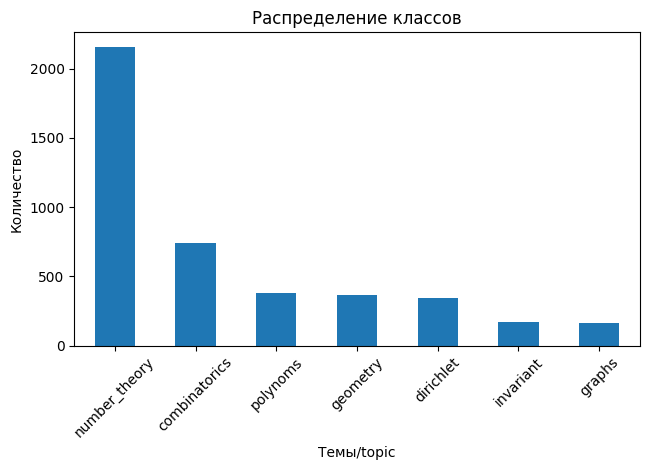

In [18]:
class_counts = data['topic'].value_counts()

# Выведем количество данных по каждой теме
print(class_counts)

# Построим график распределения классов
class_counts.plot(kind='bar')
plt.title('Распределение классов')
plt.xlabel('Темы/topic')
plt.xticks(rotation=45)
plt.tight_layout()
plt.ylabel('Количество')
plt.show()

In [19]:
data.columns

Index(['Unnamed: 0', 'problem_text', 'topic', 'cleaned_text', 'bert_tokens'], dtype='object')

In [20]:
!pip install argostranslate


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 13.8 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 45.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 13.3 MB/s eta 0:00:00
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895239 sha256=3a27349ba442d09ab345a33e3f8d56464092403e91d2fe0723a2140c1ac27f14
  Stored in directory: /root/.cache/pip/wheels/00/24/97/a2ea5324f36bc626e1ea0267f33db6aa80d157ee977e9e42fb
Successfully built sacremoses
  Attempting uninstall: sentencepiece
    Found existing installation: sentencepiece 0.2.0
    Uninstalling sentencepiece-0.2.0:
      Successfully uninstalled sentencepiece-0.2.0


In [21]:
from argostranslate import package
available_packages = package.get_available_packages()
print(available_packages)


[Albanian -> English, Arabic -> English, Azerbaijani -> English, Bengali -> English, Bulgarian -> English, Catalan -> English, Chinese (traditional) -> English, Chinese -> English, Czech -> English, Danish -> English, Dutch -> English, English -> Albanian, English -> Arabic, English -> Azerbaijani, English -> Bengali, English -> Bulgarian, English -> Catalan, English -> Chinese, English -> Chinese (traditional), English -> Czech, English -> Danish, English -> Dutch, English -> Esperanto, English -> Estonian, English -> Finnish, English -> French, English -> German, English -> Greek, English -> Hebrew, English -> Hindi, English -> Hungarian, English -> Indonesian, English -> Irish, English -> Italian, English -> Japanese, English -> Korean, English -> Latvian, English -> Lithuanian, English -> Malay, English -> Norwegian, English -> Persian, English -> Polish, English -> Portuguese, English -> Romanian, English -> Russian, English -> Slovak, English -> Slovenian, English -> Spanish, Eng

In [22]:
import argostranslate.package
import argostranslate.translate

from_code = "en"
to_code = "es"

# Download and install Argos Translate package
argostranslate.package.update_package_index()
available_packages = argostranslate.package.get_available_packages()
package_to_install = next(
    filter(
        lambda x: x.from_code == from_code and x.to_code == to_code, available_packages
    )
)
argostranslate.package.install_from_path(package_to_install.download())

# Translate
translatedText = argostranslate.translate.translate("Hello World", from_code, to_code)
print(translatedText)

Hola Mundo


In [23]:
import argostranslate.package
import argostranslate.translate

# Обновление списка доступных пакетов
argostranslate.package.update_package_index()
available_packages = argostranslate.package.get_available_packages()

# Установка пакета для перевода с английского на испанский
en_to_es_package = next(
    filter(
        lambda x: x.from_code == "en" and x.to_code == "es", available_packages
    )
)
argostranslate.package.install_from_path(en_to_es_package.download())

# Установка пакета для перевода с испанского на английский
es_to_en_package = next(
    filter(
        lambda x: x.from_code == "es" and x.to_code == "en", available_packages
    )
)
argostranslate.package.install_from_path(es_to_en_package.download())


In [24]:
import argostranslate.translate
print(dir(argostranslate.translate))


['CachedTranslation', 'CompositeTranslation', 'FewShotTranslation', 'Hypothesis', 'ILanguageModel', 'ITranslation', 'IdentityTranslation', 'InstalledTranslate', 'Language', 'LibreTranslateTranslation', 'List', 'Package', 'PackageTranslation', 'RemoteTranslation', 'Translator', '__annotations__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '__warningregistry__', 'annotations', 'apis', 'apply_packaged_translation', 'ctranslate2', 'fewshot', 'get_installed_languages', 'get_language_from_code', 'get_translation_from_codes', 'info', 'installed_translates', 'load_installed_languages', 'package', 'sbd', 'settings', 'spm', 'stanza', 'translate']


In [25]:
import argostranslate.translate

# Загрузка доступных переводов
argostranslate.translate.load_installed_languages()

def back_translate(text, from_code="en", to_code="es"):
    # Получение функций перевода
    translate_from = argostranslate.translate.get_translation_from_codes(from_code, to_code)
    translate_to = argostranslate.translate.get_translation_from_codes(to_code, from_code)

    if translate_from and translate_to:
        # Перевод текста на испанский и обратно на английский
        translated = translate_from.translate(text)
        back_translated = translate_to.translate(translated)
        return back_translated
    else:
        return "Translation models are not properly loaded."

# Тестирование функции
test_text = "Mathematical problems often need creative solutions."
back_translated_text = back_translate(test_text)
print("Original:", test_text)
print("Back-translated:", back_translated_text)


Original: Mathematical problems often need creative solutions.
Back-translated: Mathematical problems often need creative solutions.


In [26]:
data.head()

,Unnamed: 0,problem_text,topic,cleaned_text,bert_tokens
0,0,To prove that the sum of the numbers of the ex...,number_theory,To prove that the sum of the numbers of the ex...,"[To, pro, ##ve, that, the, sum, of, the, num, ..."
1,1,( b) Will the statement of the previous challe...,number_theory,( b) Will the statement of the previous challe...,"[(, b, ), Will, the, stat, ##ement, of, the, p..."
2,2,The quadratic three-member graph with the coef...,polynoms,The quadratic three-member graph with the coef...,"[The, qu, ##ad, ##rat, ##ic, th, ##ree, -, me,..."
3,3,Can you draw on the surface of Rubik's cube a ...,combinatorics,Can you draw on the surface of Rubik's cube a ...,"[Can, you, dr, ##aw, on, the, sur, ##face, of,..."
4,4,"Dima, who came from Vrunlandia, said that ther...",graphs,"Dima, who came from Vrunlandia, said that ther...","[Dim, ##a, ,, who, cam, ##e, from, V, ##run, #..."


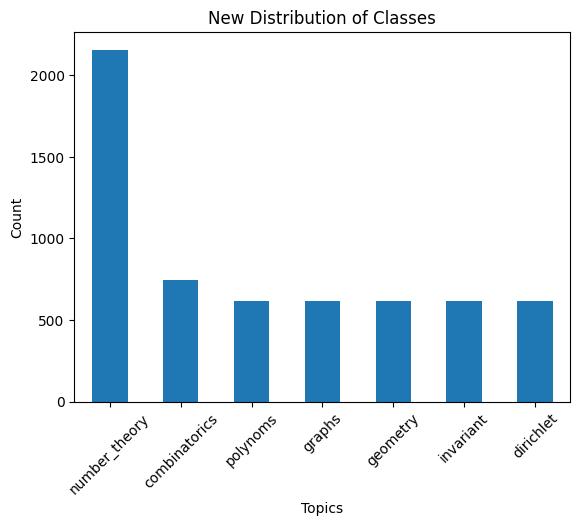

In [27]:
import pandas as pd
import numpy as np

# Вычисление среднего количества примеров на класс
threshold = class_counts.mean()

# Создаем пустой DataFrame для аугментированных данных
augmented_data = pd.DataFrame(columns=data.columns)

# Проходим по каждому классу и аугментируем при необходимости
for topic, group in data.groupby('topic'):
    count = len(group)
    if count < threshold:
        # Сколько примеров нужно аугментировать
        augment_count = int(threshold - count)
        # Выбор случайных примеров для аугментации
        sample = group.sample(n=augment_count, replace=True)
        # Применение back translation
        sample['problem_text'] = sample['problem_text'].apply(lambda x: back_translate(x))
        # Обновление bert_tokens, если это необходимо, можно опустить или обновить позже
        # sample['bert_tokens'] = None
        # Добавление аугментированных данных
        augmented_data = pd.concat([augmented_data, sample])

# Объединение аугментированных данных с исходным датасетом
augmented_dataset = pd.concat([data, augmented_data], ignore_index=True)

# Проверка нового распределения классов
new_class_counts = augmented_dataset['topic'].value_counts()
new_class_counts.plot(kind='bar')
plt.title('New Distribution of Classes')
plt.xlabel('Topics')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show()


In [28]:
# Проверка на дубликаты по колонке с текстом задач
duplicates = augmented_dataset.duplicated(subset=['problem_text'], keep=False)

# Подсчет количества дубликатов
num_duplicates = duplicates.sum()
print(f'Количество дубликатов: {num_duplicates}')

# Отображение дубликатов, если они есть
if num_duplicates > 0:
    print(augmented_dataset[duplicates].sort_values(by=['problem_text']))


Количество дубликатов: 1296
     Unnamed: 0                                       problem_text     topic  \
5978       4302                                        (a) (b) (g)  polynoms   
3669       4302                                        (a) (b) (g)  polynoms   
5867       4302                                        (a) (b) (g)  polynoms   
5261       1929  (a) Each city is connected to each of the othe...    graphs   
5247       1929  (a) Each city is connected to each of the othe...    graphs   
...         ...                                                ...       ...   
4877        827  n students want to share equal m of chocolate,...    graphs   
5904        656  where ck coefficients can be found using the f...  polynoms   
5931        656  where ck coefficients can be found using the f...  polynoms   
5971       1295  x1 is the actual root of the equation x2 + ax ...  polynoms   
5936       1295  x1 is the actual root of the equation x2 + ax ...  polynoms   

           

In [29]:
# Удаление дубликатов, оставляя только первое уникальное вхождение
augmented_dataset = augmented_dataset.drop_duplicates(subset=['cleaned_text'], keep='first')

# Сброс индексов после удаления дубликатов
augmented_dataset.reset_index(drop=True, inplace=True)

# Проверяем размер датасета после удаления дубликатов
print(f'Количество записей после удаления дубликатов: {len(augmented_dataset)}')


Количество записей после удаления дубликатов: 4319


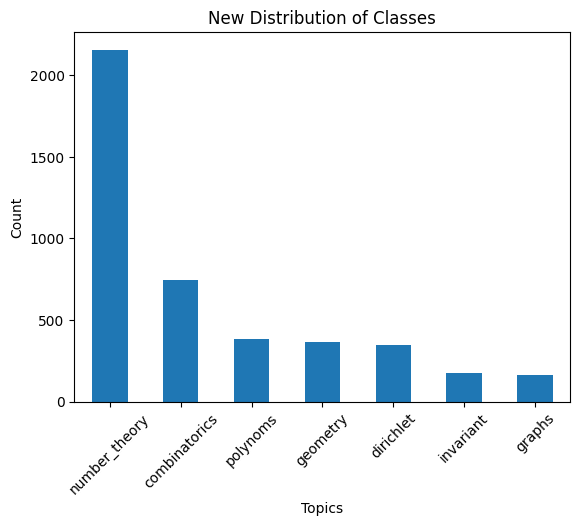

topic
number_theory    2156
combinatorics     743
polynoms          380
geometry          364
dirichlet         344
invariant         172
graphs            160
Name: count, dtype: int64


In [30]:
new_class_counts = augmented_dataset['topic'].value_counts()
new_class_counts.plot(kind='bar')
plt.title('New Distribution of Classes')
plt.xlabel('Topics')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show()

print(new_class_counts)


In [32]:
augmented_dataset.describe

<bound method NDFrame.describe of      Unnamed: 0                                       problem_text  \
0             0  To prove that the sum of the numbers of the ex...   
1             1  ( b) Will the statement of the previous challe...   
2             2  The quadratic three-member graph with the coef...   
3             3  Can you draw on the surface of Rubik's cube a ...   
4             4  Dima, who came from Vrunlandia, said that ther...   
...         ...                                                ...   
4314       5268  Can the number n! end with the figures of 76.0...   
4315       5269   Find all natural m and n for which m! + 12 = n2.   
4316       5270  The correct 5,000-column has a 2001 vertebrate...   
4317       5271  Find the maximum number N for which there are ...   
4318       5272  (a) Of the 19 balls, 2 are radioactive. It is ...   

              topic                                       cleaned_text  \
0     number_theory  To prove that the sum of the n

In [33]:
# Сохраняем DataFrame в CSV-файл
augmented_dataset.to_csv('augmented_dataset.csv', index=False)
